# 12 Review of rampup-v3 with A2C

The observation in v3 is changed because it is not neccessary to provide the entire demand array. A preprocessed datum can compress all required information and discard irrelevant details. Information on precise demand is moved from the observation space to the info bit of `step()`.

In [1]:
import os
import subprocess
import webbrowser

from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

from plan_opt.create import env_cb_creator
from plan_opt.demand import Demand
from plan_opt.demand_small_samples import four_weeks_uprising
from plan_opt.env_health import env_health
from plan_opt.train_eval3 import train_and_evaluate

With default policy settings, training is worse and less stable.

In [2]:
config = {
    # ENVIRONMENT CONFIGURATION
    "ENV_ID": "rampup-v3",
    "REWARD_THRESHOLD": 80,
    "PUNISH_ILLEGAL": True,
    # WORKFLOW CONFIGURATION
    "TENSORBOARD_LOG": "logs/rampup_tensorboard/",
    "TIMESTEPS": 100000,
    "REPETITIONS": 1,
    "EVAL_EPISODES": 50,
    "SHOW_TABLE": False,
    "LEARNING_RATE": 0.0007,
    "POLICY_KWARGS": {
        "optimizer_class": RMSpropTFLike,
        "optimizer_kwargs": {
            "alpha": 0.99,
            "eps": 1e-5,
            "weight_decay": 0,
        },
    },
}

In [3]:
tb_suffix = ""
tb_suffix += f"_{str(config['TIMESTEPS'])[:-3]}k"
if config["PUNISH_ILLEGAL"]:
    tb_suffix += f"_legal_chg"
tb_suffix

'_100k_legal_chg'

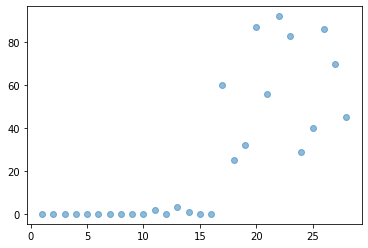

In [4]:
demand_4W = Demand(period=len(four_weeks_uprising), data=four_weeks_uprising)
env_4W, eval_callback_4W, demand_4W = env_cb_creator(config, demand_4W)

### Quick Health Check
- The observation is much neater compared to earlier versions

In [5]:
env_health(config, env_4W, first_step=False, random_steps=3, verbose=0)

Random step:	 0
Timestep:	 6 
Action:		 1 
Demand:		 0 
Reward:		 -2000 
Done:		 False 
Info:		 
  timestep_change          5 -> 6
  action_change            0 -> 1
  demand_surrounding       [0]-NOW(0)-[0 0 0]
  next_profitable_demand   13
  demand_observation       0.07692307978868484 
Shape:		 (5,) 
Observation:
 [0.07692308 0.         1.         0.         0.        ] 

Random step:	 1
Timestep:	 6 
Action:		 1 
Demand:		 0 
Reward:		 -2000 
Done:		 False 
Info:		 
  timestep_change          5 -> 6
  action_change            0 -> 1
  demand_surrounding       [0]-NOW(0)-[0 0 0]
  next_profitable_demand   13
  demand_observation       0.07692307978868484 
Shape:		 (5,) 
Observation:
 [0.07692308 0.         1.         0.         0.        ] 

Random step:	 2
Timestep:	 15 
Action:		 3 
Demand:		 0 
Reward:		 -500 
Done:		 False 
Info:		 
  timestep_change          14 -> 15
  action_change            2 -> 3
  demand_surrounding       [0]-NOW(0)-[60 25 32]
  next_profitable_demand   4
 

### Train and Evaluate
Results look much more promising, as illegal moves are clearly learned and avoided. There are significant differences between repetitions!

In [6]:
best_model, train_env, eval_env = train_and_evaluate(
    config=config,
    train_env=env_4W,
    eval_env=env_4W,
    eval_callback=eval_callback_4W,
    tb_log_name=f"A2C_train4W_eval4W_{tb_suffix}",
)


Running repetition 1/1...
POLICY EVALUATION RESULTS
Evaluated episodes:	50
Mean reward:		32130.0
Standard deviation:	16189.752932024627
Economic potential:	41000
Lost potential:		8870.0 (21.6341%)


15 repetitions over 150k episodes show results with variance remaining when applying the models!

![Evaluation](docs/nb12-eval.png)

### Tensorboard

In [7]:
if 1 == 0:
    pid = subprocess.Popen(
        ["tensorboard", "--logdir", f"./{config['TENSORBOARD_LOG']}", "--port", "6006"]
    )
    os.system("sleep 5")
    webbrowser.open("http://localhost:6006")